In [ ]:
#| code-fold: true
#| code-summary: "Show setup code"
!pip install -qq diffusers transformers==4.46.2
!pip install -qq pillow==11.0.0

from diffusers import LMSDiscreteScheduler, AutoencoderKL, UNet2DConditionModel, StableDiffusionPipeline
from transformers import CLIPTextModel, CLIPTokenizer
from PIL import Image
from tqdm.auto import tqdm
from IPython.display import display
import matplotlib.pyplot as plt
import pandas as pd
import torch, math

tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=torch.float16)
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=torch.float16).to("cuda")
vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-ema", torch_dtype=torch.float16).to("cuda")
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet", torch_dtype=torch.float16).to("cuda")

beta_start,beta_end = 0.00085,0.012
scheduler = LMSDiscreteScheduler(beta_start=beta_start, beta_end=beta_end, beta_schedule="scaled_linear", num_train_timesteps=1000)

height = 512
width = 512
num_inference_steps = 70
guidance_scale = 7.5
batch_size = 1

## Background

In this notebook, I'll explore the question: how different are UNet predictions (in latent space) for the conditioned and unconditioned (empty) prompts? The 
code used in this notebook comes from the ["Stable Diffusion with Diffusers"](https://github.com/fastai/diffusion-nbs/blob/master/stable_diffusion.ipynb) from 
part 2 of the fastai course.

## Generating Images

I'll start by running the code below to generate an image using stable diffusion:

- `text_enc` tokenizes the given prompt and converts it to text embeddings using the `text_encoder`("openai/clip-vit-large-patch14").
- `mk_img` converts a Tensor to a PIL Image.
- `mk_samples` takes the prompt, guidance scale, seed, and number of inference steps to run the diffusion loop and generate a image using the `scheduler` (`LMSDiscreteScheduler`), UNet (`"CompVis/stable-diffusion-v1-4"`) and VAE (`"stabilityai/sd-vae-ft-ema"`).

In [2]:
def text_enc(prompts, maxlen=None):
    if maxlen is None: maxlen = tokenizer.model_max_length
    inp = tokenizer(prompts, padding="max_length", max_length=maxlen, truncation=True, return_tensors="pt")
    return text_encoder(inp.input_ids.to("cuda"))[0].half()

def mk_img(t):
    image = (t/2+0.5).clamp(0,1).detach().cpu().permute(1, 2, 0).numpy()
    return Image.fromarray((image*255).round().astype("uint8"))

In [3]:
def mk_samples(prompts, g=7.5, seed=100, steps=70):
    bs = len(prompts)
    text = text_enc(prompts)
    uncond = text_enc([""] * bs, text.shape[1])
    emb = torch.cat([uncond, text])
    if seed: torch.manual_seed(seed)

    latents = torch.randn((bs, unet.in_channels, height//8, width//8))
    scheduler.set_timesteps(steps)
    latents = latents.to("cuda").half() * 15

    for i,ts in enumerate(tqdm(scheduler.timesteps)):
        inp = scheduler.scale_model_input(torch.cat([latents] * 2), ts)
        with torch.no_grad(): u,t = unet(inp, ts, encoder_hidden_states=emb).sample.chunk(2)
        pred = u + g*(t-u)
        latents = scheduler.step(pred, ts, latents).prev_sample

    with torch.no_grad(): return vae.decode(1 / 0.18215 * latents).sample

/tmp/ipykernel_34/2926544816.py:8: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents = torch.randn((bs, unet.in_channels, height//8, width//8))


  0%|          | 0/70 [00:00<?, ?it/s]

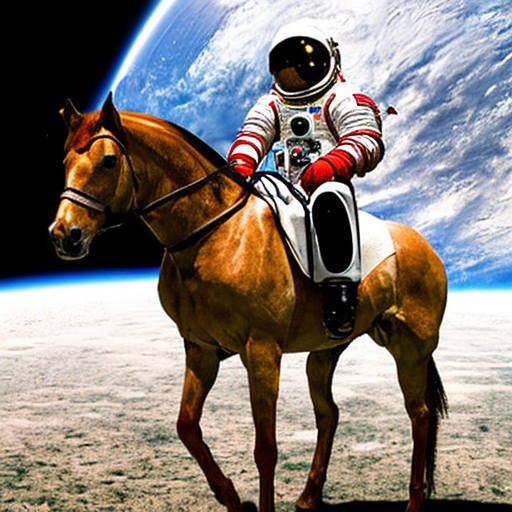

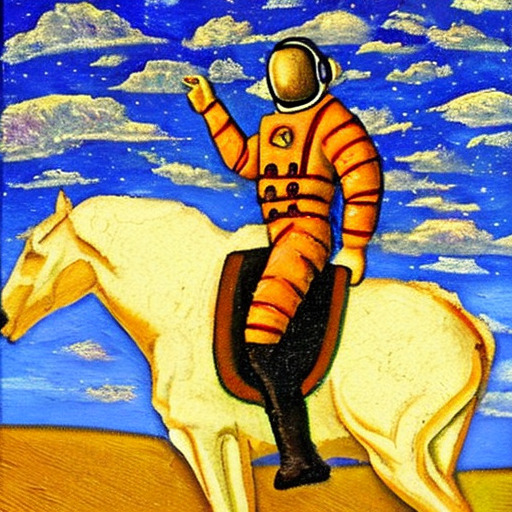

In [4]:
prompts = [
    'a photograph of an astronaut riding a horse',
    'an oil painting of an astronaut riding a horse in the style of grant wood'
]

images = mk_samples(prompts)
for img in images: display(mk_img(img))

The two images are generated as expected!

## Classifier-Free Guidance

The lines of code I'm most interested in for this notebook are:

```python
with torch.no_grad(): u,t = unet(inp, ts, encoder_hidden_states=emb).sample.chunk(2)
pred = u + g*(t-u)
```

In the first line, the `unet` takes the noisy input latents `inp`, timestep `ts` and text embeddings `emb` to predict the noise in the noisy latent. In the 
second line, the "final" prediction is taken as `u + g*(t-u)` where `t` and `u` are both predictions form the same UNet:

- `u` is the predicted noise corresponding to the unconditioned prompt (`""`).
- `t` is the predicted noise corresponding to the conditioned prompt (e.g., `'a photograph of an astronaut riding a horse'`),
- `g` is the _guidance scale_ which is the amount we want to weight the prediction towards `t` and away from `u`.

Expanding this equation we get: `pred = u + gt - gu = gt - (g-1)u`. We amplify `t` by `g` and then subtract `(g-1)` times `u`. Conceptually, we are moving 
away from the empty prompt and toward the desired prompt. My understanding of why we need `u` is that we need a baseline or reference point to which we compare 
`t` so that we can guide the generation process to learn specific features of `t` in comparison to general noisy features of of `u`. This "comparison" is done 
with the `t-u` term.

## Cosine Similarity Between `u` and `t`

I'm going to modify `mk_samples` so that at each timestep, it calculates and stores the cosine similarity betwern `t` and `u`:

In [6]:
#| code-fold: true
#| code-summary: "Show modified `mk_samples` function"
def mk_samples(prompts, g=7.5, seed=100, steps=70):
    cs = []
    bs = len(prompts)
    text = text_enc(prompts)
    uncond = text_enc([""] * bs, text.shape[1])
    emb = torch.cat([uncond, text])
    if seed: torch.manual_seed(seed)

    latents = torch.randn((bs, unet.in_channels, height//8, width//8))
    scheduler.set_timesteps(steps)
    latents = latents.to("cuda").half() * 15

    for i,ts in enumerate(tqdm(scheduler.timesteps)):
        inp = scheduler.scale_model_input(torch.cat([latents] * 2), ts)
        with torch.no_grad(): u,t = unet(inp, ts, encoder_hidden_states=emb).sample.chunk(2)
       
        cs.append(torch.nn.functional.cosine_similarity(t, u).mean().item())
        
        pred = u + g*(t-u)
        latents = scheduler.step(pred, ts, latents).prev_sample

    with torch.no_grad(): 
        return vae.decode(1 / 0.18215 * latents).sample, cs

/tmp/ipykernel_34/1126956742.py:9: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents = torch.randn((bs, unet.in_channels, height//8, width//8))


  0%|          | 0/70 [00:00<?, ?it/s]

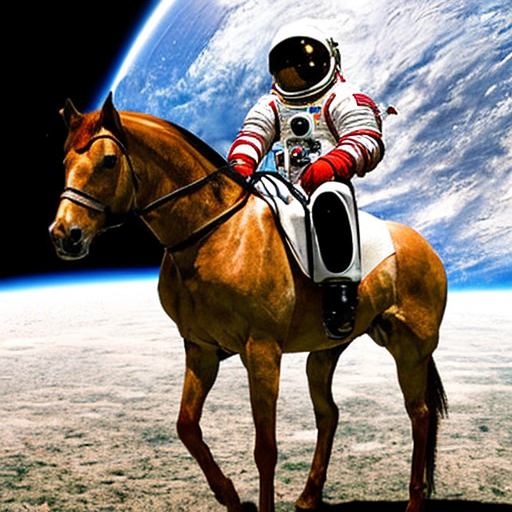

In [7]:
prompts = [
    'a photograph of an astronaut riding a horse'
]

images, cs = mk_samples(prompts)
for img in images: display(mk_img(img))

I was shocked to find that the cosine similarity between the unconditioned and the conditioned UNet predictions is so high! Essentially 1.0!!

In [8]:
pd.Series(cs).describe()

count    70.000000
mean      0.999616
std       0.000261
min       0.998535
25%       0.999512
50%       0.999512
75%       0.999878
max       1.000000
dtype: float64

The two predictions start out basically exactly the same (cosine similarity = 1) and diverge as the diffusion process goes on, reaching the lowest 
cosine similarity at the 70 inference steps.

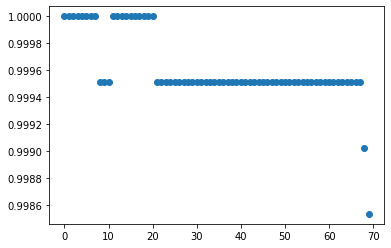

In [10]:
plt.scatter(range(len(cs)),cs);

This trend of high mean similarity between `t` and `u` overall and decreasing cosine similarity over time holds for other prompts as well:

/tmp/ipykernel_34/1126956742.py:9: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents = torch.randn((bs, unet.in_channels, height//8, width//8))


  0%|          | 0/70 [00:00<?, ?it/s]

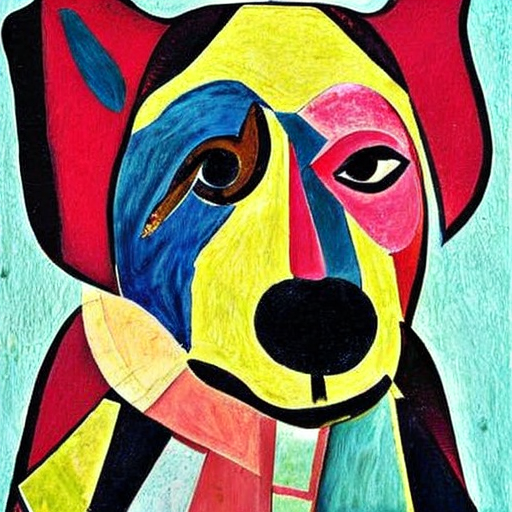

In [11]:
prompts = [
    'a painting of a dog in the style of Picasso'
]

images, cs = mk_samples(prompts)
for img in images: display(mk_img(img))

In [12]:
pd.Series(cs).describe()

count    70.000000
mean      0.999923
std       0.000197
min       0.999023
25%       1.000000
50%       1.000000
75%       1.000000
max       1.000000
dtype: float64

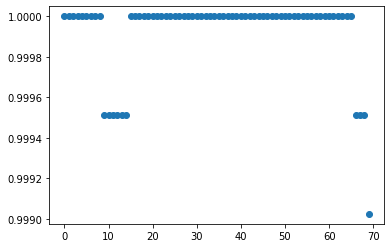

In [13]:
plt.scatter(range(len(cs)),cs);

/tmp/ipykernel_34/1126956742.py:9: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents = torch.randn((bs, unet.in_channels, height//8, width//8))


  0%|          | 0/70 [00:00<?, ?it/s]

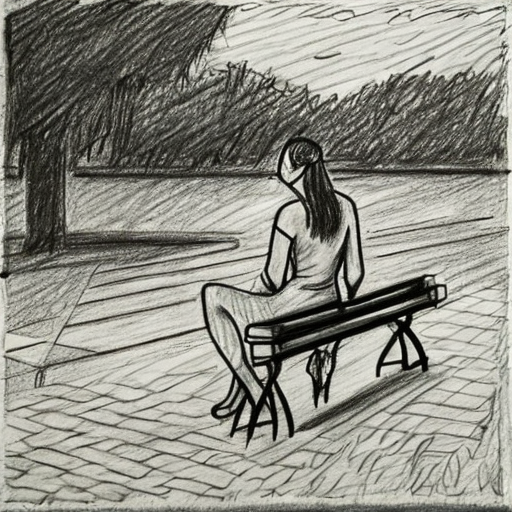

In [14]:
prompts = [
    'a drawing of a woman sitting on a park bench'
]

images, cs = mk_samples(prompts)
for img in images: display(mk_img(img))

In [15]:
pd.Series(cs).describe()

count    70.000000
mean      0.999679
std       0.000233
min       0.999512
25%       0.999512
50%       0.999512
75%       1.000000
max       1.000000
dtype: float64

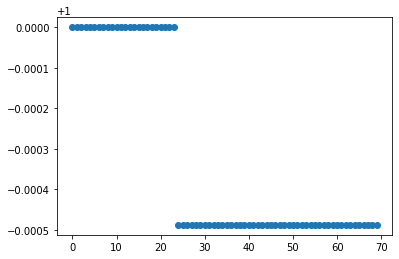

In [16]:
plt.scatter(range(len(cs)),cs);

## Perturbations in `pred`

My takeaway from the high cosine similarity between conditioned and unconditioned predictions is that the diffusion process is sensitive to small 
perturbations. However, I found that this wasn't _always_ the case. To illustrate, I'll first add a large amount of noise to `pred` at each timestep and see how that impacts the resulting image.

In [63]:
#| code-fold: true
#| code-summary: "Show modified `mk_samples` function"
def mk_samples(prompts, g=7.5, seed=100, steps=70):
    cs = []
    bs = len(prompts)
    text = text_enc(prompts)
    uncond = text_enc([""] * bs, text.shape[1])
    emb = torch.cat([uncond, text])
    if seed: torch.manual_seed(seed)

    latents = torch.randn((bs, unet.in_channels, height//8, width//8))
    scheduler.set_timesteps(steps)
    latents = latents.to("cuda").half() * 15

    for i,ts in enumerate(tqdm(scheduler.timesteps)):
        inp = scheduler.scale_model_input(torch.cat([latents] * 2), ts)
        with torch.no_grad(): u,t = unet(inp, ts, encoder_hidden_states=emb).sample.chunk(2)
       
        cs.append(torch.nn.functional.cosine_similarity(t, u).mean().item())
        
        r = 0.1*torch.randn_like(t)
        orig_pred = u + g*(t-u)
        pred = u + g*(t-u) + r
        
        latents = scheduler.step(pred, ts, latents).prev_sample

    with torch.no_grad(): 
        return vae.decode(1 / 0.18215 * latents).sample, cs, orig_pred, r

/tmp/ipykernel_34/2326634756.py:9: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents = torch.randn((bs, unet.in_channels, height//8, width//8))


  0%|          | 0/70 [00:00<?, ?it/s]

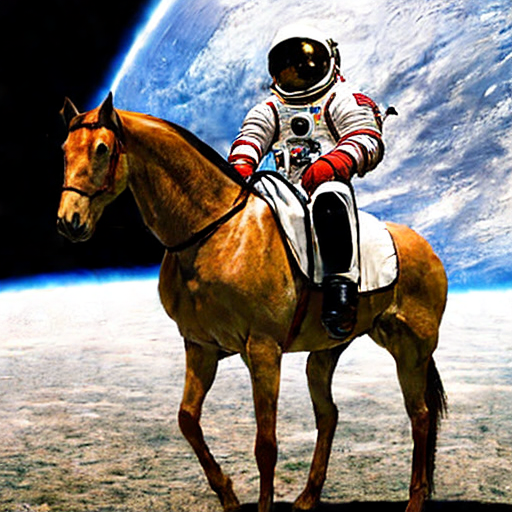

In [64]:
prompts = [
    'a photograph of an astronaut riding a horse'
]

images, cs, orig_pred, r = mk_samples(prompts)
for img in images: display(mk_img(img))

In [65]:
orig_pred.norm(), r.norm()

(tensor(27.3281, device='cuda:0', dtype=torch.float16),
 tensor(12.6328, device='cuda:0', dtype=torch.float16))

Adding a noise tensor with about half of the magnitude as the full noise prediction did not prevent the diffusion loop from generating a high quality image!  At what point does random noise impact generation?

In [81]:
def mk_samples(prompts, g=7.5, seed=100, steps=70):
    cs = []
    bs = len(prompts)
    text = text_enc(prompts)
    uncond = text_enc([""] * bs, text.shape[1])
    emb = torch.cat([uncond, text])
    if seed: torch.manual_seed(seed)

    latents = torch.randn((bs, unet.in_channels, height//8, width//8))
    scheduler.set_timesteps(steps)
    latents = latents.to("cuda").half() * 15

    for i,ts in enumerate(tqdm(scheduler.timesteps)):
        inp = scheduler.scale_model_input(torch.cat([latents] * 2), ts)
        with torch.no_grad(): u,t = unet(inp, ts, encoder_hidden_states=emb).sample.chunk(2)
       
        cs.append(torch.nn.functional.cosine_similarity(t, u).mean().item())
        
        r = 0.2*torch.randn_like(t)
        orig_pred = u + g*(t-u)
        pred = u + g*(t-u) + r
        
        latents = scheduler.step(pred, ts, latents).prev_sample

    with torch.no_grad(): 
        return vae.decode(1 / 0.18215 * latents).sample, cs, orig_pred, r

/tmp/ipykernel_34/2882368180.py:9: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents = torch.randn((bs, unet.in_channels, height//8, width//8))


  0%|          | 0/70 [00:00<?, ?it/s]

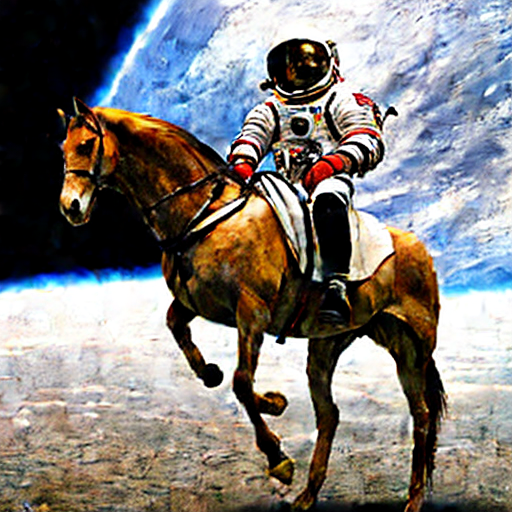

In [82]:
prompts = [
    'a photograph of an astronaut riding a horse'
]

images, cs, orig_pred, r = mk_samples(prompts)
for img in images: display(mk_img(img))

In [83]:
orig_pred.norm(), r.norm()

(tensor(26.2188, device='cuda:0', dtype=torch.float16),
 tensor(25.2656, device='cuda:0', dtype=torch.float16))

Adding random noise equal in magnitude to the guided prediction does visibly affect the quality of the generated image, though it still maintains its main 
structural components (earth, astronaut, horse).

What happens if instead of random noise, I add a UNet prediction based on some other unrelated prompt?

In [73]:
#| code-fold: true
#| code-summary: "Show modified `mk_samples` function"
def mk_samples(prompts, g=7.5, seed=100, steps=70):
    cs = []
    bs = len(prompts)
    text = text_enc(prompts)
    uncond = text_enc([""] * bs, text.shape[1])
    other = text_enc(["a toad riding a bicycle"] * bs, text.shape[1])
    
    emb = torch.cat([uncond, text, other])
    if seed: torch.manual_seed(seed)

    latents = torch.randn((bs, unet.in_channels, height//8, width//8))
    scheduler.set_timesteps(steps)
    latents = latents.to("cuda").half() * 15

    for i,ts in enumerate(tqdm(scheduler.timesteps)):
        inp = scheduler.scale_model_input(torch.cat([latents] * 3), ts)
        with torch.no_grad(): u,t,o= unet(inp, ts, encoder_hidden_states=emb).sample.chunk(3)
       
        cs.append(torch.nn.functional.cosine_similarity(t, u).mean().item())
        
        orig_pred = u + g*(t-u)
        pred = u + g*(t-u) + 0.2*o
        
        latents = scheduler.step(pred, ts, latents).prev_sample

    with torch.no_grad(): 
        return vae.decode(1 / 0.18215 * latents).sample, cs, orig_pred, o

/tmp/ipykernel_34/70226676.py:11: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents = torch.randn((bs, unet.in_channels, height//8, width//8))


  0%|          | 0/70 [00:00<?, ?it/s]

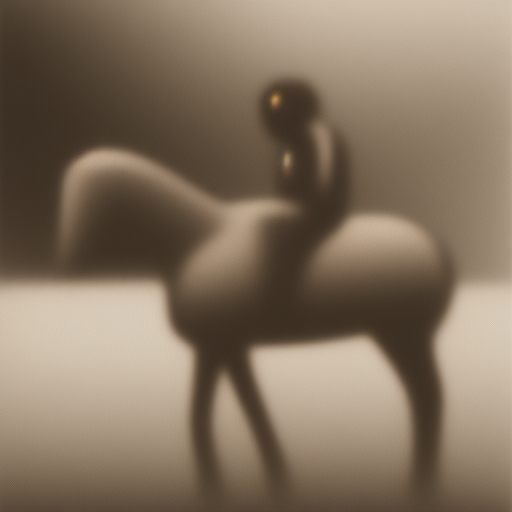

In [74]:
prompts = [
    'a photograph of an astronaut riding a horse'
]

images, cs, orig_pred, o = mk_samples(prompts)
for img in images: display(mk_img(img))

In [77]:
orig_pred.norm(), (0.2*o).norm()

(tensor(98.5625, device='cuda:0', dtype=torch.float16),
 tensor(19.9688, device='cuda:0', dtype=torch.float16))

Now that I've introduced text embeddings related to a real prompt with a similar magnitude as the random noise, it's significantly impacting the image 
generation result! Which by the way looks super cool.

/tmp/ipykernel_34/70226676.py:11: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents = torch.randn((bs, unet.in_channels, height//8, width//8))


  0%|          | 0/70 [00:00<?, ?it/s]

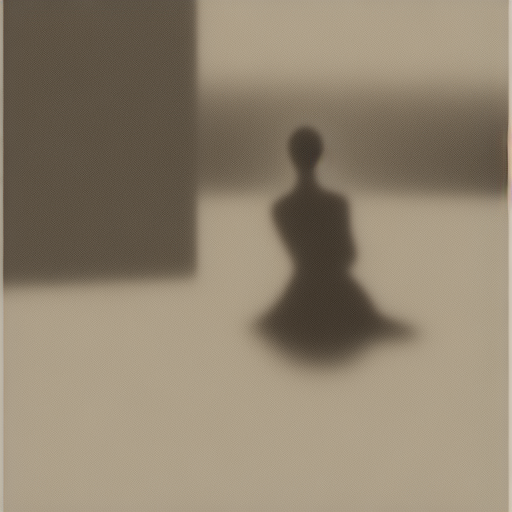

In [78]:
prompts = [
    'a drawing of a woman sitting on a park bench'
]

images, cs, orig_pred, o = mk_samples(prompts)
for img in images: display(mk_img(img))

In [79]:
orig_pred.norm(), (0.2*o).norm()

(tensor(110.1250, device='cuda:0', dtype=torch.float16),
 tensor(22.0625, device='cuda:0', dtype=torch.float16))

I get a similar result using a different prompt.

## Final Thoughts

I hesitate to make any strong conclusions about the diffusion process as I've spent only a couple dozen hours experimenting with stable diffusion, but do want to 
summarize my observations from these experiments:

- **Unconditioned and conditioned prompt UNet predictions are similar**: this was seen by the (very) high cosine similarity between the two at each time step, 
with cosine similarity decreasing as the time step increased.
- **Small amounts of random noise doesn't impact image generation**: while the term "small" is relative, adding random noise that was 50% of the original guided prediction's
norm did not visibly alter the image. Even after adding random noise with the same magnitude as the original guided prediction, the generated image still maintained its core 
composition and structure.
- **Adding another prompt's UNet predictions drastically changes the generated image**: while random noise of the same magnitude did not impact the output image, 
adding UNet predictions for an unrelated prompt completely changes the color, features and structure of the image (while still maintaining some thematic elements). 


These observations make me wonder the following questions, that I'll keep in mind throughout part 2 of the fastai course:

- Is the small difference in direction between `t` and `u` the reason we need relatively large guidance scale values? Is it also the reason why if the guidance scale 
is too large, we start losing structural features of the desired prompt/image?
- Does the fact that structured UNet predictions (as opposed to random noise) impact image generation significantly mean that UNet's are not sensitive to random noise but
 are generally susceptible to structured data in the latent space? Why is that?
 
 I hope you enjoyed this blog post!